In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from tensorflow.keras.applications import DenseNet121
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Custom callback to stop training when accuracy and val_accuracy reach 98%
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        if accuracy is not None and val_accuracy is not None:
            if accuracy >= 0.98 and val_accuracy >= 0.98:
                print("\nReached 98% accuracy and validation accuracy, stopping training.")
                self.model.stop_training = True

In [4]:
# Path to your dataset
dataset_path = '/content/drive/MyDrive/Gigi Tampak Depan'

In [5]:
# Image dimensions
img_height, img_width = 224, 224
batch_size = 32

In [6]:
# Prepare the dataset with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Using 20% of the data for validation
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)


Found 3905 images belonging to 5 classes.
Found 973 images belonging to 5 classes.


In [7]:
# Load the DenseNet model pre-trained on ImageNet, excluding the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

29084464/29084464 [==============================] - 0s 0us/step


In [8]:
# Freeze the layers of DenseNet
base_model.trainable = False

In [9]:
# Add custom layers on top of DenseNet
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
prediction = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=prediction)

In [10]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

In [12]:
# Define callbacks
checkpoint = ModelCheckpoint("Densenet.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
custom_callback = CustomCallback()

callbacks = [checkpoint, early_stopping, reduce_lr, custom_callback]


In [13]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks
)

Epoch 1/50
123/123 [==============================] - ETA: 0s - loss: 0.9318 - accuracy: 0.6589
Epoch 1: val_accuracy improved from -inf to 0.71429, saving model to Densenet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


123/123 [==============================] - 1396s 11s/step - loss: 0.9318 - accuracy: 0.6589 - val_loss: 0.6852 - val_accuracy: 0.7143 - lr: 0.0010
Epoch 2/50
123/123 [==============================] - ETA: 0s - loss: 0.6105 - accuracy: 0.7670
Epoch 2: val_accuracy improved from 0.71429 to 0.78417, saving model to Densenet.h5
123/123 [==============================] - 93s 754ms/step - loss: 0.6105 - accuracy: 0.7670 - val_loss: 0.5187 - val_accuracy: 0.7842 - lr: 0.0010
Epoch 3/50
123/123 [==============================] - ETA: 0s - loss: 0.5417 - accuracy: 0.7913
Epoch 3: val_accuracy improved from 0.78417 to 0.79753, saving model to Densenet.h5
123/123 [==============================] - 91s 741ms/step - loss: 0.5417 - accuracy: 0.7913 - val_loss: 0.4746 - val_accuracy: 0.7975 - lr: 0.0010
Epoch 4/50
123/123 [==============================] - ETA: 0s - loss: 0.5089 - accuracy: 0.8015
Epoch 4: val_accuracy did not improve from 0.79753
123/123 [==============================] - 90s 735ms

In [14]:
from google.colab import files
files.download('Densenet.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Test accuracy: {accuracy:.2f}')

31/31 [==============================] - 120s 4s/step - loss: 0.4511 - accuracy: 0.8412
Test accuracy: 0.84


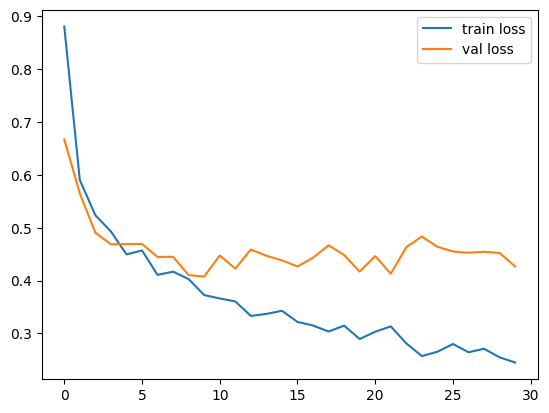

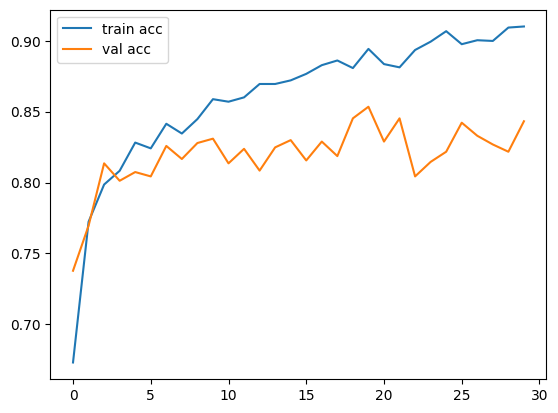

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# Plot the Loss and Accuracy
# Loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# Accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [15]:
# Fine-tuning: Unfreeze the top layers of the model and re-train
base_model.trainable = True

In [16]:
# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
# Define callbacks
checkpoint = ModelCheckpoint("Densenet_fine_tuning.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
custom_callback = CustomCallback()

callbacks = [checkpoint, early_stopping, reduce_lr, custom_callback]


In [18]:
# Train the model again with fine-tuning
history_fine = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,  # Additional epochs for fine-tuning
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks
)

Epoch 1/50
123/123 [==============================] - ETA: 0s - loss: 0.5913 - accuracy: 0.7846
Epoch 1: val_accuracy improved from -inf to 0.80678, saving model to Densenet_fine_tuning.h5
123/123 [==============================] - 177s 890ms/step - loss: 0.5913 - accuracy: 0.7846 - val_loss: 0.5777 - val_accuracy: 0.8068 - lr: 1.0000e-05
Epoch 2/50
123/123 [==============================] - ETA: 0s - loss: 0.4607 - accuracy: 0.8184
Epoch 2: val_accuracy did not improve from 0.80678
123/123 [==============================] - 103s 830ms/step - loss: 0.4607 - accuracy: 0.8184 - val_loss: 0.5342 - val_accuracy: 0.8068 - lr: 1.0000e-05
Epoch 3/50
123/123 [==============================] - ETA: 0s - loss: 0.3656 - accuracy: 0.8612
Epoch 3: val_accuracy improved from 0.80678 to 0.83864, saving model to Densenet_fine_tuning.h5
123/123 [==============================] - 104s 842ms/step - loss: 0.3656 - accuracy: 0.8612 - val_loss: 0.4163 - val_accuracy: 0.8386 - lr: 1.0000e-05
Epoch 4/50
123/1

In [ ]:
# Evaluate the fine-tuned model
loss, accuracy = model.evaluate(validation_generator)
print(f'Fine-tuned test accuracy: {accuracy:.2f}')

In [19]:
# Predict the labels for the validation dataset
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

31/31 [==============================] - 22s 632ms/step


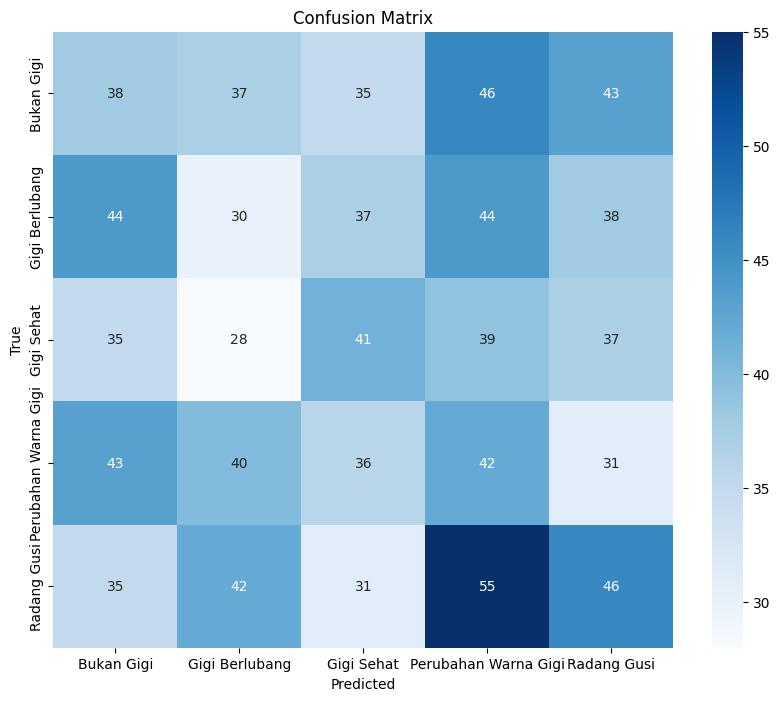

In [20]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [21]:
# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices.keys()))

                      precision    recall  f1-score   support

          Bukan Gigi       0.19      0.19      0.19       199
      Gigi Berlubang       0.17      0.16      0.16       193
          Gigi Sehat       0.23      0.23      0.23       180
Perubahan Warna Gigi       0.19      0.22      0.20       192
         Radang Gusi       0.24      0.22      0.23       209

            accuracy                           0.20       973
           macro avg       0.20      0.20      0.20       973
        weighted avg       0.20      0.20      0.20       973

